In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [62]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [63]:
print(tf.__version__)

2.12.0


In [64]:
tf.random.set_seed(42)
np.random.seed(42)

In [65]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(4596, 15) (1314, 15) (630, 15)


## `DataWindow` class 

In [66]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [67]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [68]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [69]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [70]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [71]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

41/41 [==============================] - 0s 2ms/step - loss: 2.6052 - mean_absolute_error: 0.8984


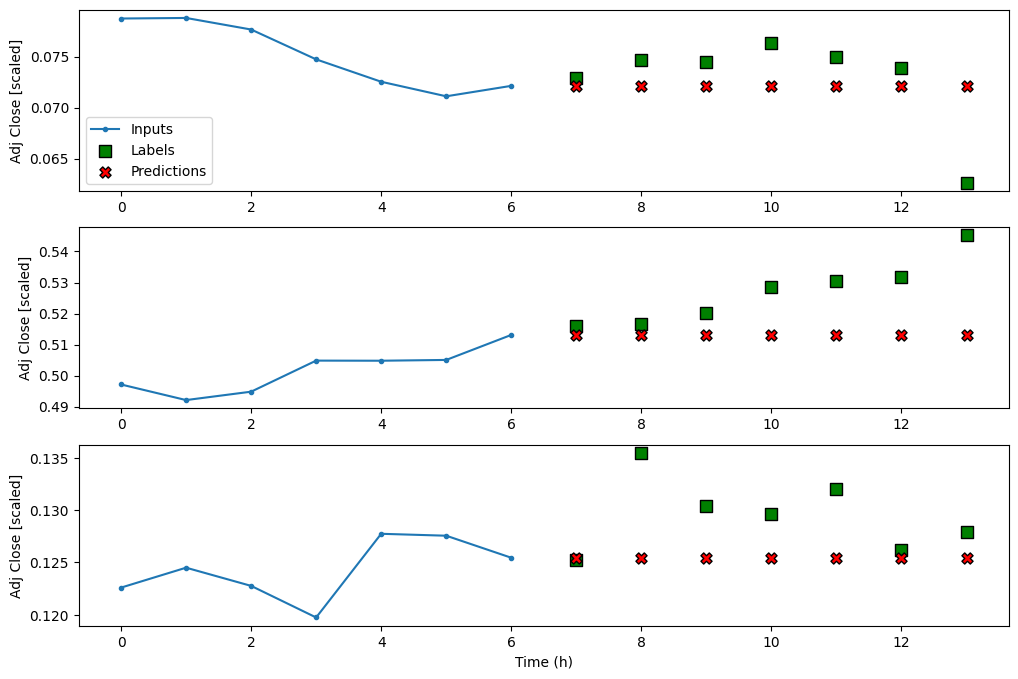

In [72]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [73]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [74]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

41/41 [==============================] - 0s 806us/step - loss: 2.6106 - mean_absolute_error: 0.9095


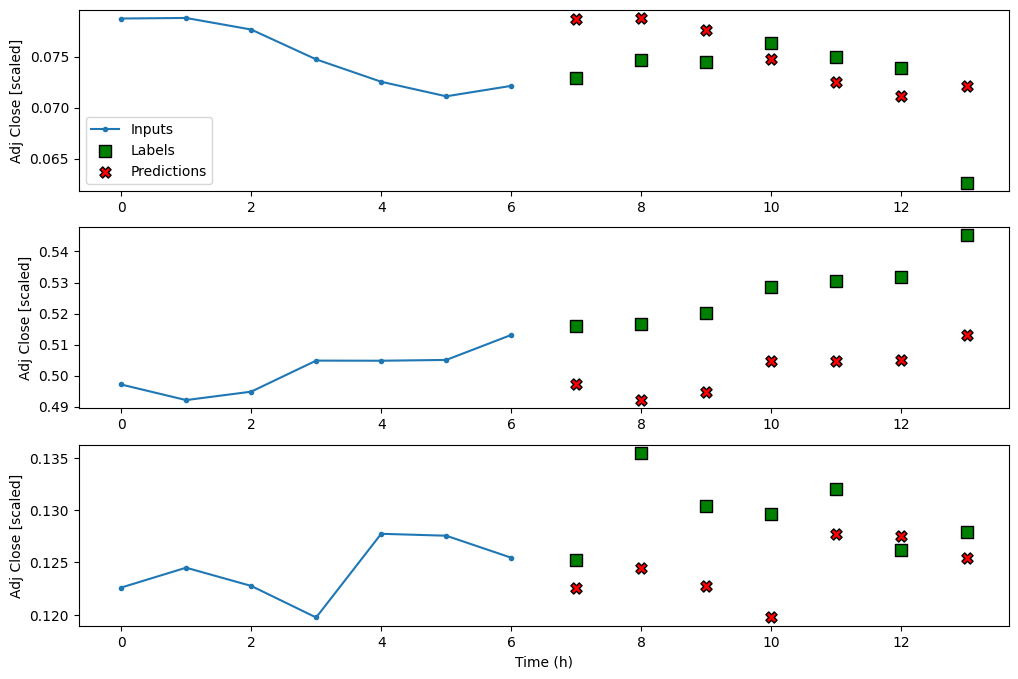

In [75]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [76]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 1s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0860 - val_loss: 0.3681 - val_mean_absolute_error: 0.5191
Epoch 2/1000
144/144 [==============================] - 0s 1ms/step - loss: 9.0567e-04 - mean_absolute_error: 0.0232 - val_loss: 0.0378 - val_mean_absolute_error: 0.1387
Epoch 3/1000
144/144 [==============================] - 0s 1ms/step - loss: 3.3629e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0263 - val_mean_absolute_error: 0.1076
Epoch 4/1000
144/144 [==============================] - 0s 1ms/step - loss: 3.0774e-04 - mean_absolute_error: 0.0112 - val_loss: 0.0258 - val_mean_absolute_error: 0.1060
Epoch 5/1000
144/144 [==============================] - 0s 1ms/step - loss: 2.9685e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0253 - val_mean_absolute_error: 0.1043
Epoch 6/1000
144/144 [==============================] - 0s 1ms/step - loss: 2.9148e-04 - mean_absolute_error: 0.0106 - val_loss: 0.0250 - val_mean_absolut

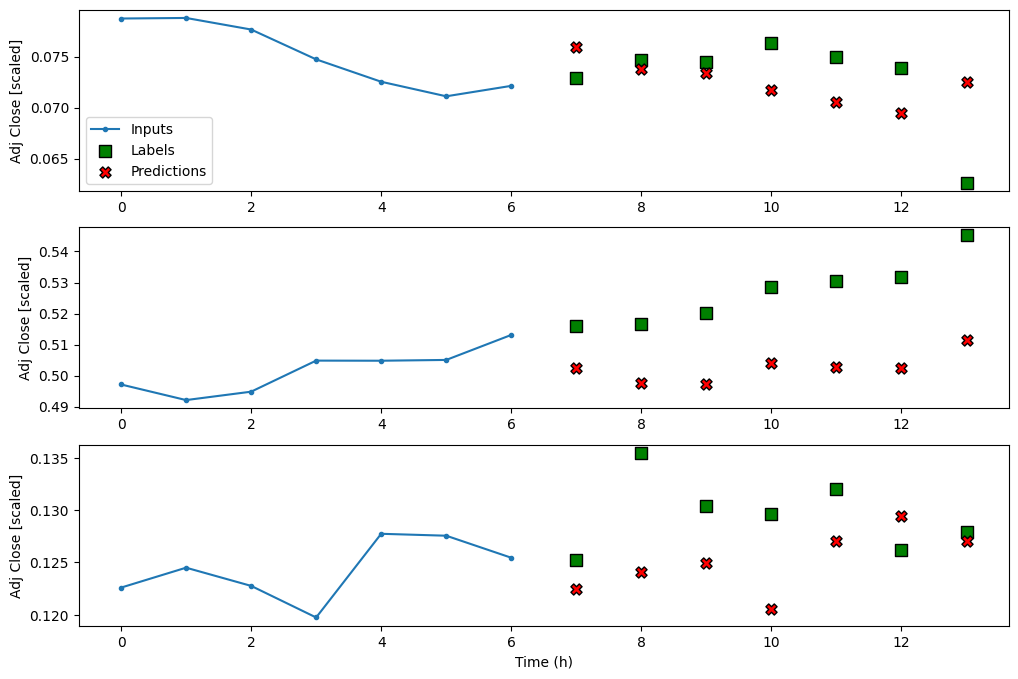

In [77]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [78]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 1s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0435 - val_loss: 0.0354 - val_mean_absolute_error: 0.1296
Epoch 2/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.0649e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0260 - val_mean_absolute_error: 0.1057
Epoch 3/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.0140e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0316 - val_mean_absolute_error: 0.1208
Epoch 4/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.0564e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0342 - val_mean_absolute_error: 0.1280
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0351 - mean_absolute_error: 0.1308


## LSTM model 

In [79]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 2s 5ms/step - loss: 0.0163 - mean_absolute_error: 0.0691 - val_loss: 3.5782 - val_mean_absolute_error: 1.4596
Epoch 2/1000
144/144 [==============================] - 1s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0193 - val_loss: 3.0088 - val_mean_absolute_error: 1.3100
Epoch 3/1000
144/144 [==============================] - 0s 3ms/step - loss: 3.8467e-04 - mean_absolute_error: 0.0128 - val_loss: 2.9252 - val_mean_absolute_error: 1.2779
Epoch 4/1000
144/144 [==============================] - 0s 3ms/step - loss: 3.1868e-04 - mean_absolute_error: 0.0114 - val_loss: 2.9084 - val_mean_absolute_error: 1.2691
Epoch 5/1000
144/144 [==============================] - 0s 3ms/step - loss: 3.0901e-04 - mean_absolute_error: 0.0112 - val_loss: 2.8846 - val_mean_absolute_error: 1.2581
Epoch 6/1000
144/144 [==============================] - 0s 3ms/step - loss: 3.0648e-04 - mean_absolute_error: 0.0111 - val_loss: 2.8708 - val_mean_absolute_er

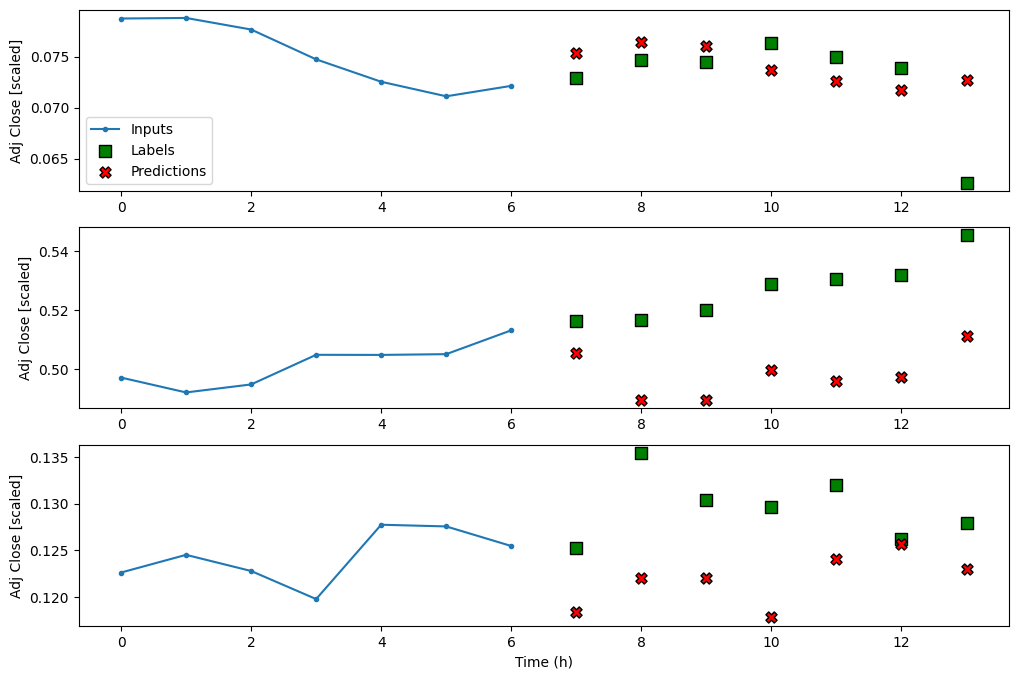

In [80]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [81]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [82]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 1s 2ms/step - loss: 0.0112 - mean_absolute_error: 0.0512 - val_loss: 0.0506 - val_mean_absolute_error: 0.1622
Epoch 2/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.3344e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0432 - val_mean_absolute_error: 0.1472
Epoch 3/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.2729e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0400 - val_mean_absolute_error: 0.1407
Epoch 4/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.0889e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0356 - val_mean_absolute_error: 0.1303
Epoch 5/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.1391e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0570 - val_mean_absolute_error: 0.1772
Epoch 6/1000
144/144 [==============================] - 0s 2ms/step - loss: 3.1746e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0422 - val_mean_absolut

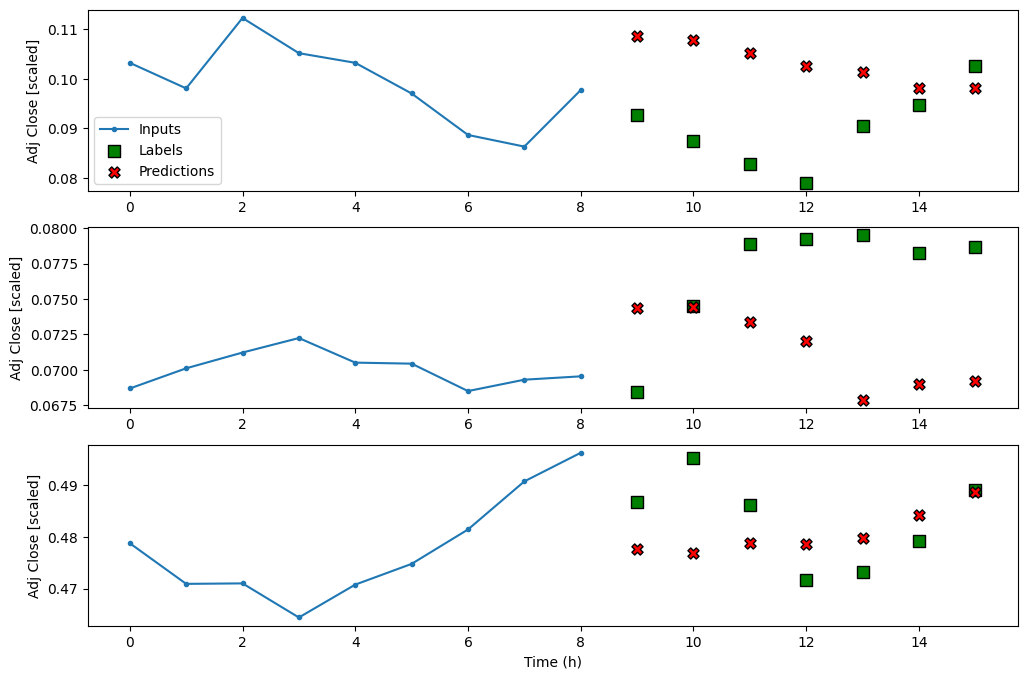

In [83]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [84]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 2s 6ms/step - loss: 0.0144 - mean_absolute_error: 0.0597 - val_loss: 4.5995 - val_mean_absolute_error: 1.7155
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 5.3948e-04 - mean_absolute_error: 0.0146 - val_loss: 4.3414 - val_mean_absolute_error: 1.6388
Epoch 3/1000
144/144 [==============================] - 1s 3ms/step - loss: 4.2052e-04 - mean_absolute_error: 0.0130 - val_loss: 4.1320 - val_mean_absolute_error: 1.5764
Epoch 4/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.8884e-04 - mean_absolute_error: 0.0125 - val_loss: 4.0207 - val_mean_absolute_error: 1.5500
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.5876e-04 - mean_absolute_error: 0.0120 - val_loss: 3.8745 - val_mean_absolute_error: 1.5033
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.4845e-04 - mean_absolute_error: 0.0118 - val_loss: 3.8066 - val_mean_absolut

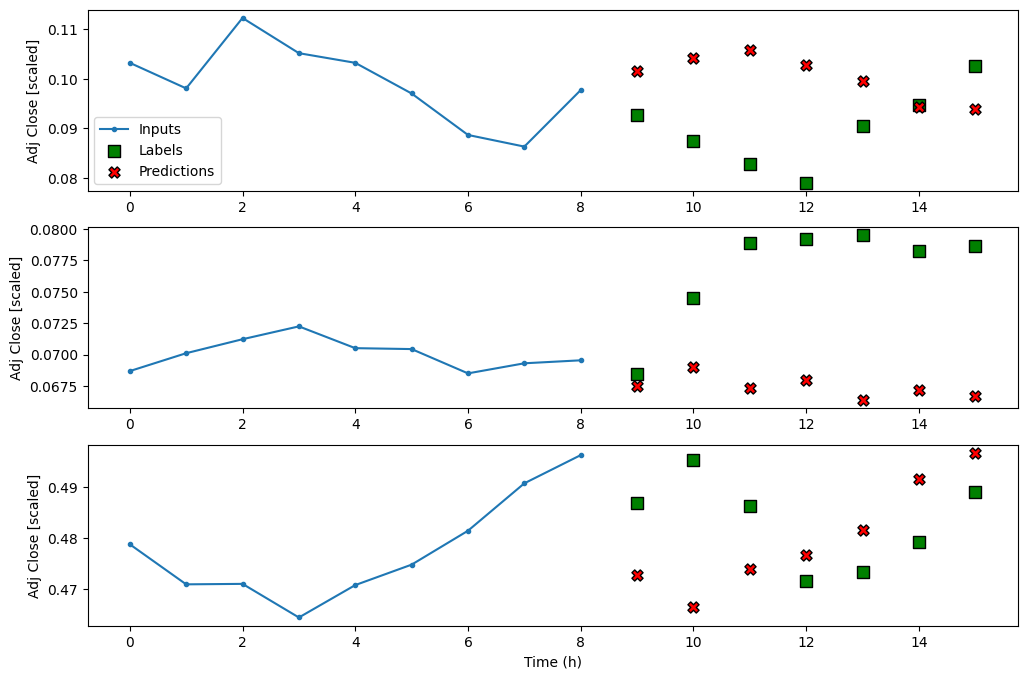

In [85]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [86]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [87]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 2s 5ms/step - loss: 0.0111 - mean_absolute_error: 0.0528 - val_loss: 4.5269 - val_mean_absolute_error: 1.6873
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 5.8270e-04 - mean_absolute_error: 0.0170 - val_loss: 4.2099 - val_mean_absolute_error: 1.5991
Epoch 3/1000
144/144 [==============================] - 1s 4ms/step - loss: 4.6977e-04 - mean_absolute_error: 0.0147 - val_loss: 4.1323 - val_mean_absolute_error: 1.5772
Epoch 4/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.7052e-04 - mean_absolute_error: 0.0127 - val_loss: 4.0214 - val_mean_absolute_error: 1.5449
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 2.9895e-04 - mean_absolute_error: 0.0114 - val_loss: 3.8934 - val_mean_absolute_error: 1.5029
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 2.7914e-04 - mean_absolute_error: 0.0108 - val_loss: 3.8710 - val_mean_absolut

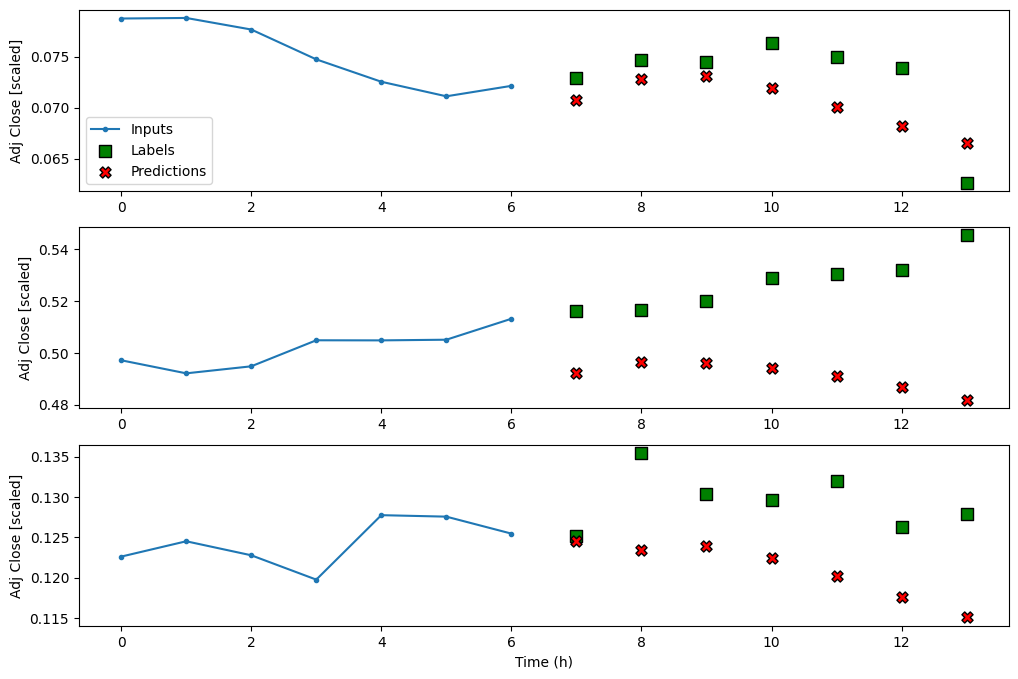

In [88]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [89]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
144/144 [==============================] - 3s 7ms/step - loss: 0.0153 - mean_absolute_error: 0.0635 - val_loss: 4.5985 - val_mean_absolute_error: 1.6994
Epoch 2/1000
144/144 [==============================] - 1s 4ms/step - loss: 4.9864e-04 - mean_absolute_error: 0.0144 - val_loss: 4.2861 - val_mean_absolute_error: 1.6106
Epoch 3/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.8379e-04 - mean_absolute_error: 0.0125 - val_loss: 4.0919 - val_mean_absolute_error: 1.5542
Epoch 4/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.6589e-04 - mean_absolute_error: 0.0123 - val_loss: 3.9819 - val_mean_absolute_error: 1.5227
Epoch 5/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.8009e-04 - mean_absolute_error: 0.0125 - val_loss: 3.8558 - val_mean_absolute_error: 1.4759
Epoch 6/1000
144/144 [==============================] - 1s 4ms/step - loss: 3.9841e-04 - mean_absolute_error: 0.0127 - val_loss: 3.8268 - val_mean_absolut

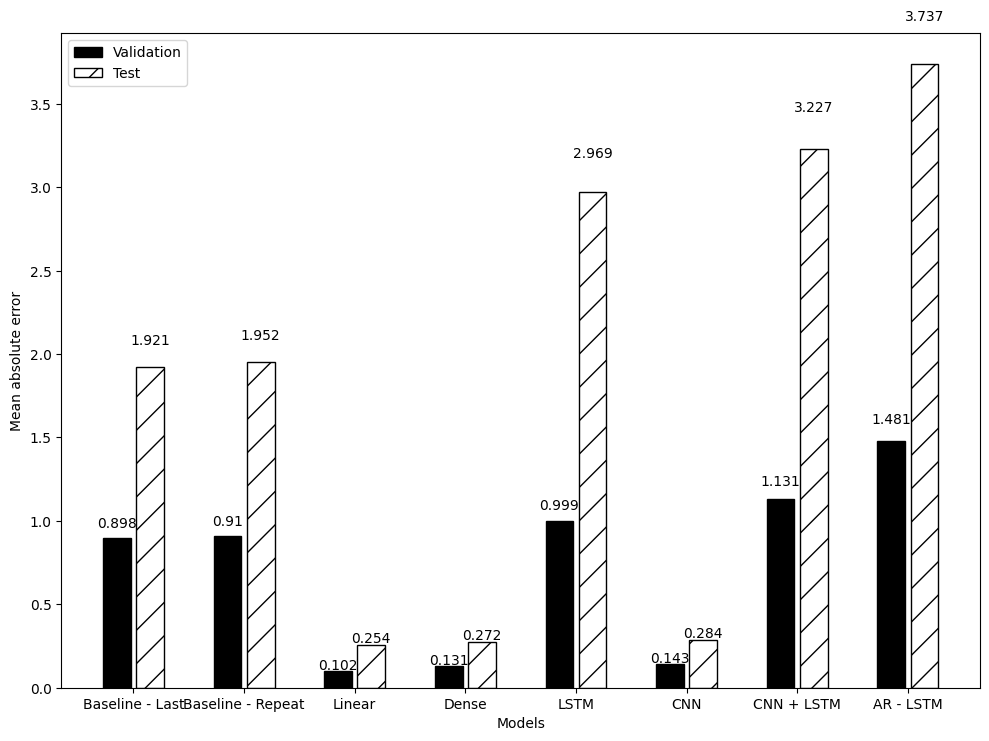

In [90]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)